In [1]:
# keras==2.2.4
# tensorflow==1.14.0

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
import cv2
import os, gc
import keras
import keras.backend as K
from keras.utils import np_utils
from keras.models import Model, load_model, model_from_json
from keras.layers import Input, Conv2D,MaxPooling2D,Dense, Flatten,Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

/home/wenboc/anaconda3/envs/smerf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/wenboc/anaconda3/envs/smerf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/wenboc/anaconda3/envs/smerf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/wenboc/anaconda3/envs/smerf/lib/python3.6/s

## Load data

In [3]:
single_channel = True
groups = ["G2","notG2"]
nb_classes = len(groups)

In [4]:
# load training and test data sets
x_train = np.load('random_train_x.npy')
y_train = np.load('random_train_y.npy')
y_train = np.where(y_train > 0, 1, 0)

x_test = np.load('random_test_x.npy')
y_test = np.load('random_test_y.npy')
y_test = np.where(y_test > 0, 1, 0)

# normalize
x_train = x_train/255
x_test = x_test/255

y_train = np_utils.to_categorical(y_train,nb_classes)
y_test = np_utils.to_categorical(y_test,nb_classes)

# pick color channels
if single_channel:
    x_train=x_train[...,0]
    x_test=x_test[...,0]
    x_train=x_train[...,None]
    x_test=x_test[...,None]

print(x_train.shape)
print(x_test.shape)

(1884, 128, 128, 1)
(116, 128, 128, 1)


## Model definition

In [5]:
def def_model(drop, hidden_layers, nb_batch, neurons):
    neurons=int(neurons)
    hidden_layers=int(hidden_layers)

    # input layer
    inputs = Input(shape=x_train.shape[1:])

    x = Conv2D(neurons, (3, 3), padding='same', activation='relu')(inputs)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # hidden layers
    if hidden_layers !=0:
        for i in range(1,hidden_layers+1):
            x = Conv2D(neurons*(2**i), (3, 3), padding='same', activation='relu')(x)
            x = MaxPooling2D((2, 2), padding='same')(x)

    x = Flatten()(x)
    x = Dense(neurons*(2**(hidden_layers+1)), activation='relu')(x)
    x = Dropout(drop)(x)

    # output
    predictions = Dense(nb_classes, activation='softmax')(x)

    # modeling
    model = Model(inputs=inputs, outputs=predictions)

    model.compile(optimizer='rmsprop',
                            loss='binary_crossentropy',
                            metrics=['accuracy'])
    return model

In [6]:
def train_model(drop,hidden_layers,nb_batch,neurons):  
    nb_epoch=100

    model = def_model(drop, hidden_layers, nb_batch, neurons)
    
    early_stopping = EarlyStopping(patience=10, verbose=1)

    # learning
    hist = model.fit(x_train, y_train, validation_split=0.2, epochs=int(nb_epoch), 
                     batch_size=int(nb_batch),callbacks=[early_stopping])
    
    return model

In [7]:
first_channel_param = 0.13791859009269297,4.926228876231845,52.22902820499593,13.29955867002539
all_channel_param = 0.456104728569606,3.2342069340199053,24.48398957474884,2.900128967117457
first_channel_blank_param = 0.04066267075109985,4.459168975123963,93.69830910390179,6.555398874756942
random_first_channel_param = 0.0,4.1041481666223385,80.77401259480031,5.93002356405143

In [8]:
# first_channel_model = train_model(*first_channel_param)
# all_channel_model = train_model(*all_channel_param)
# first_channel_blank_model = train_model(*first_channel_blank_param)
# random_first_channel_model = train_model(*random_first_channel_param)

In [10]:
# first_channel_model.save('first_channel_model.h5')
# all_channel_model.save('all_channel_model.h5')
# first_channel_blank_model.save('first_channel_blank_model.h5')
# random_first_channel_model.save('random_first_channel_model.h5')

In [9]:
first_channel_model = load_model('first_channel_model.h5')
all_channel_model = load_model('all_channel_model.h5')
first_channel_blank_model = load_model('first_channel_blank_model.h5')
random_first_channel_model = load_model('random_first_channel_model.h5')


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



## GradCam

In [10]:
def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                tf.cast(op.inputs[0] > 0., dtype)

def compile_saliency_function(model, activation_layer='block5_pool'):
    input_img = model.input
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output = layer_dict[activation_layer].output
    max_output = K.max(layer_output, axis=3)
    saliency = K.gradients(K.sum(max_output), input_img)[0]
    return K.function([input_img, K.learning_phase()], [saliency])

def modify_backprop(model, name, model_file):
    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:] 
                      if hasattr(layer, 'activation')]

        # replace relu activation
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu

        # re-instanciate a new model
        if model_file == 'first_channel_model.h5':
            new_model = def_model(*first_channel_param)
        elif model_file == 'first_channel_blank_model.h5':
            new_model = def_model(*first_channel_blank_param)
        elif model_file == 'random_first_channel_model.h5':
            new_model = def_model(*random_first_channel_param)
        else:
            new_model = def_model(*all_channel_param)

        new_model.load_weights(model_file)
    return new_model


def grad_cam(model, x, category_index, layer_name):
    """
    Args:
       model: model
       x: image input
       category_index: category index
       layer_name: last convolution layer name
    """
    # get category loss
    class_output = model.output[:, category_index]

    # layer output
    convolution_output = model.get_layer(layer_name).output
    # get gradients
    grads = K.gradients(class_output, convolution_output)[0]
    # get convolution output and gradients for input
    gradient_function = K.function([model.input], [convolution_output, grads])

    output, grads_val = gradient_function([x])
    output, grads_val = output[0], grads_val[0]

    # avg
    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # create heat map
    cam = cv2.resize(cam, (x.shape[1], x.shape[2]), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)

    # Return to BGR [0..255] from the preprocessed image
    image_rgb = x[0, :]
    image_rgb -= np.min(image_rgb)
    image_rgb = np.minimum(image_rgb, 255)
    
    cam = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam) + np.float32(image_rgb)
    cam = 255 * cam / np.max(cam)
    return np.uint8(cam), heatmap

In [11]:
def grad_cam_run(model, x_sample, model_file):
    last_conv_layer_name = [x for x in model.layers if type(x) == keras.layers.convolutional.Conv2D][-1].name
    cam_imgs = np.zeros((x_sample.shape[0], x_sample.shape[1], x_sample.shape[2], 3))
    heat_maps = np.zeros(x_sample.shape)
    grad_cam_imgs = np.zeros(x_sample.shape)
    for i in range(x_sample.shape[0]):
        img = x_sample[i][None,:,:,:]
        predictions = model.predict(img)
        pred_class = predictions.argmax(axis=1)[0]
        cam_image, heat_map = grad_cam(model, img, pred_class, last_conv_layer_name)

        # guided grad_cam img 
        register_gradient()
        guided_model = modify_backprop(model, 'GuidedBackProp', model_file)
        guided_model_name = [x for x in guided_model.layers if type(x) == keras.layers.convolutional.Conv2D][-1].name
        saliency_fn = compile_saliency_function(guided_model, activation_layer=guided_model_name)
        saliency = saliency_fn([img, 0])
        grad_cam_img = saliency[0] * heat_map[..., np.newaxis]

        if np.max(grad_cam_img) - np.min(grad_cam_img) != 0:
            grad_cam_img = (grad_cam_img - np.min(grad_cam_img)) / (np.max(grad_cam_img) - np.min(grad_cam_img))


        cam_imgs[i] = cam_image
        
        heat_maps[i] = np.repeat(heat_map[:, :, np.newaxis], 1, axis=2)
        
        grad_cam_imgs[i] = grad_cam_img[0]
    del guided_model
    gc.collect()
    return cam_imgs, heat_maps, grad_cam_imgs

In [12]:
# test_x = x_test[:20]
c, h, g = grad_cam_run(random_first_channel_model, x_test, 'random_first_channel_model.h5')
# c, h, g = grad_cam_run(first_channel_model, test_x, 'first_channel_model.h5')
# c, h, g = grad_cam_run(first_channel_blank_model, test_x, 'first_channel_blank_model.h5')
# c, h, g = grad_cam_run(all_channel_model, test_x, 'all_channel_model.h5')

In [13]:
with open('h.npy', 'wb') as f:
    np.save(f, h)

In [15]:
# with open('g.npy', 'wb') as f:
#     np.save(f, g)

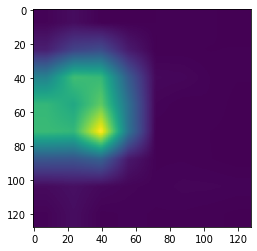

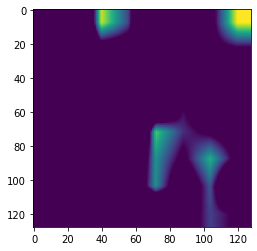

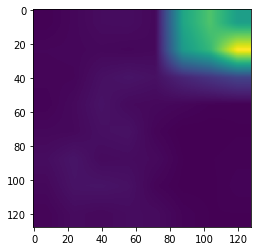

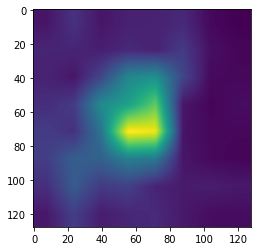

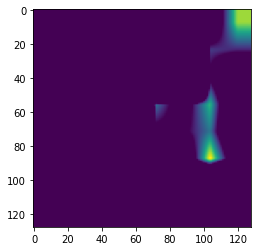

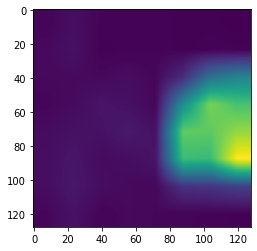

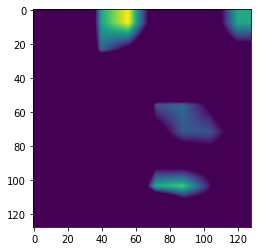

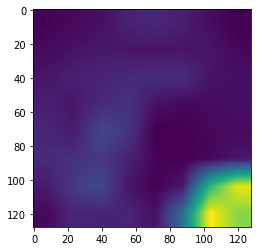

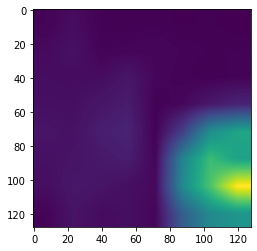

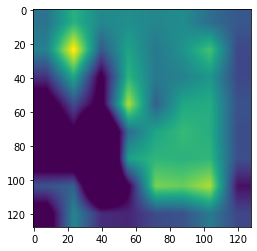

In [16]:
for i in range(10):
    plt.figure()
    plt.imshow(h[i][:,:,0])

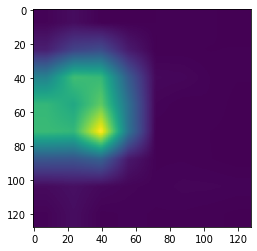

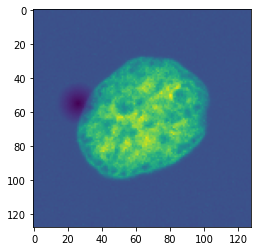

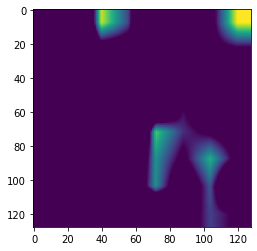

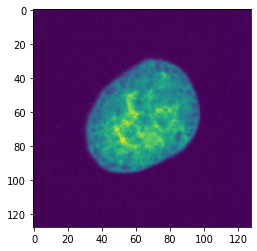

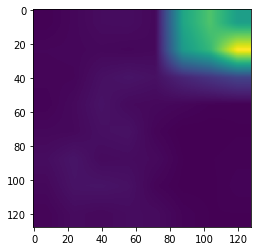

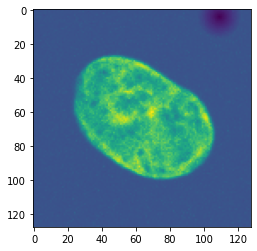

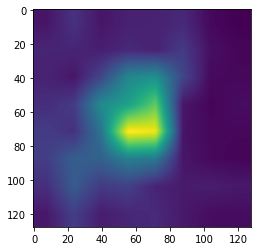

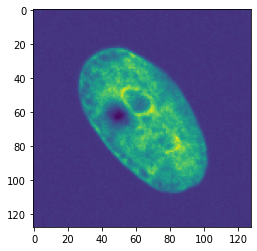

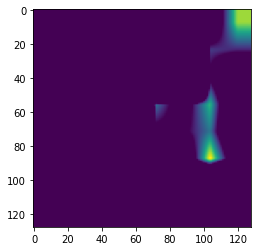

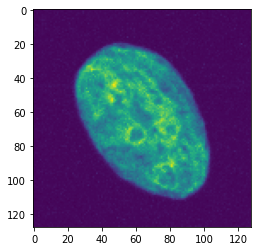

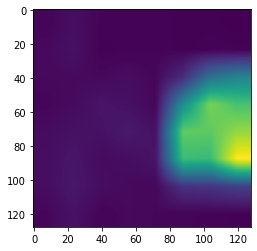

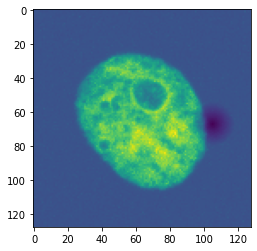

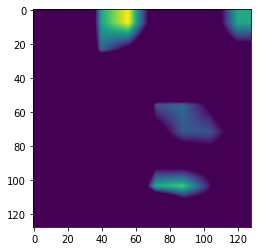

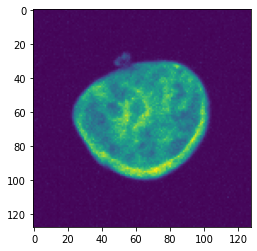

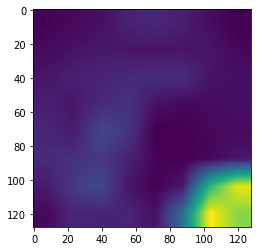

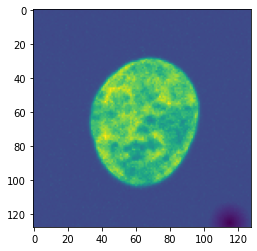

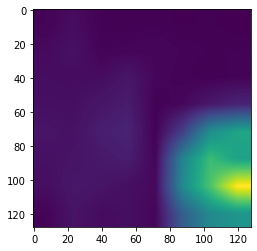

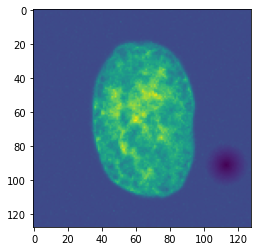

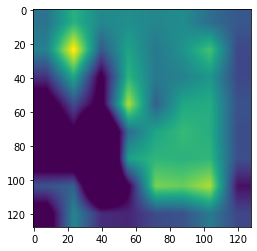

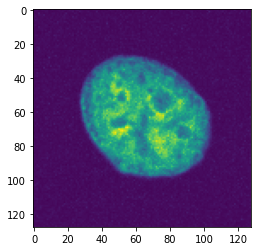

In [17]:
for i in range(10):
    plt.figure()
    plt.imshow(h[i][:,:,0])
    plt.figure()
#     plt.imshow(g[i][:,:,0])
#     plt.figure()
    plt.imshow(test_x[i][:,:,0])